In [266]:
# Dependencies and Setup
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import re
import os

In [267]:
# Dependencies for ML
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.ensemble import RandomForestClassifier
from imblearn.combine import SMOTEENN
from imblearn.metrics import classification_report_imbalanced
from imblearn.ensemble import BalancedRandomForestClassifier

In [268]:
# Read the preprocessed data into a Pandas DataFrame
file_path = "./Resources/Churn_Modelling_cs_lt850.csv"
clean_df = pd.read_csv(file_path)
clean_df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1


<AxesSubplot: xlabel='CreditScore', ylabel='Count'>

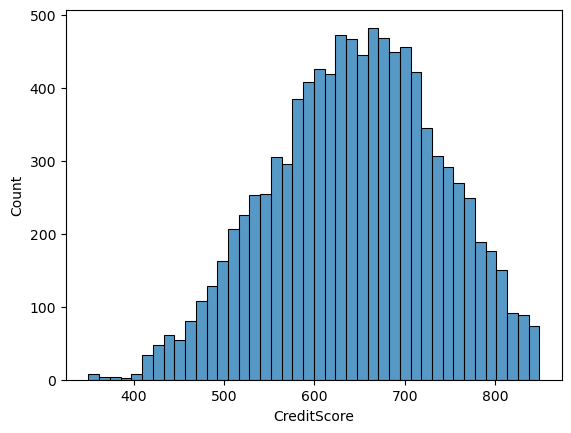

In [269]:
sns.histplot(clean_df['CreditScore'])

In [270]:
# Create our features (after dropping our target)
target = ['Exited']
X = clean_df.drop(target, axis=1)
str_cols = X.select_dtypes(include=['object']).columns
# Binary encoding using Pandas (multiple object columns)
X = pd.get_dummies(X, columns=str_cols, dtype='int')

# Create our target
y = clean_df[target]

# Check a OneHotEncoder instance
print(X.shape)
X[0:5]

(9767, 13)


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,1,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,1,0
3,699,39,1,0.00,2,0,0,93826.63,1,0,0,1,0
4,645,44,8,113755.78,2,1,0,149756.71,0,0,1,0,1


In [271]:
# Resample the training data with SMOTEENN
re_X, re_y = SMOTEENN(random_state=1).fit_resample(X, y)

In [272]:
scaler = StandardScaler()
scaler.fit(re_X)
scaled_X_train = scaler.transform(re_X)

In [273]:
# Split data into training and testing and check the balance
X_train, X_test, y_train, y_test = train_test_split(scaled_X_train, re_y, random_state=1)
y_train.value_counts()

Exited
1         2599
0         2125
dtype: int64

In [274]:
# optimal hyperparameters
formula = 'gini'
mdn = 12
nen = 90
msn = 2800
mfn = 9

def ml(criterion=formula, max_depth=mdn, estimators=nen, samples=msn, features=mfn, rfc=True):
    if rfc:
        rfc = 'RFC'
        model = RandomForestClassifier(random_state=1, max_depth=max_depth, criterion=criterion, n_estimators=estimators, max_samples=samples, max_features=features)
    else:
        rfc = 'BRFC'
        model = BalancedRandomForestClassifier(random_state=1, max_depth=max_depth, criterion=criterion, n_estimators=estimators, max_samples=samples, max_features=features)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    # Calculate the balanced accuracy score
    bacc_score = balanced_accuracy_score(y_test, y_pred)
    score = accuracy_score(y_test, y_pred)
    # Summarize the imbalanced classification report
    iclf_report = classification_report_imbalanced(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=False)
    return [bacc_score, iclf_report, y_pred, model, rfc]

## Final Optimized Model

In [275]:
formula = 'gini'
[score_m, report_m, pred_m, model_m, rfc] = ml(formula)

In [276]:
# Print the balanced accuracy score
print("Balanced Accuracy Score: %.6f" % score_m)
# Print the imbalanced classification report
print(f'Imbalanced Classification Report (criterion={formula}):\n{report_m}')

Balanced Accuracy Score: 0.900614
Imbalanced Classification Report (criterion=gini):
                   pre       rec       spe        f1       geo       iba       sup

          0       0.88      0.90      0.90      0.89      0.90      0.81       704
          1       0.92      0.90      0.90      0.91      0.90      0.81       871

avg / total       0.90      0.90      0.90      0.90      0.90      0.81      1575



In [277]:
# List the features sorted in descending order by feature importance
importances = model_m.feature_importances_
importance_df = pd.DataFrame({'feature': X.columns, 'importance': importances}).sort_values(by='importance', ascending=False)

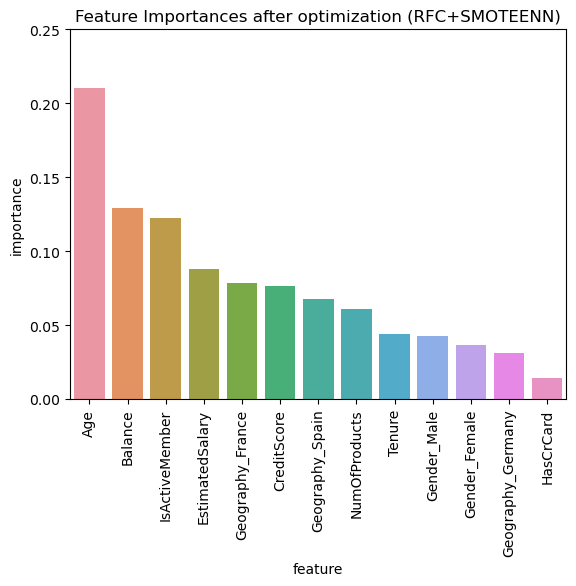

In [278]:
sns.barplot(data=importance_df, x='feature', y='importance')
plt.title(f"Feature Importances after optimization ({rfc}+SMOTEENN)")
plt.ylim(0, 0.25)
plt.xticks(rotation=90)
# Save the figure.
file_name = os.path.splitext(file_path)[0].replace('Resources', 'Data') + f'_optimized{rfc}_{formula}_FeatureImportance.png'
plt.savefig(file_name, bbox_inches='tight', facecolor='w')
# Show Figure
plt.show()

## Max Depth - max of splits
### Default - None

In [279]:
# Hyperparameter tuning comparison
depths = np.arange(1,16)
max_ml = []
for i in depths:
    max_ml.append(ml(formula, i))

In [280]:
accuracy = []
recall_1 = []
f1 = []
pred_l = []
for i in max_ml:
    accuracy.append(i[0])
    rec_1 = re.split(r'\s{2,}', i[1])[round(len(re.split(r'\s{2,}', i[1]))/2+2)]
    recall_1.append(rec_1)
    f1_avg = re.split(r'\s{2,}', i[1])[-4]
    f1.append(f1_avg)
    pred_l.append(i[2])

In [281]:
depth_df = pd.DataFrame(list(zip(accuracy, recall_1, f1)), columns=['accuracy', 'recall_1', 'f1'], index=depths, dtype='float')
depth_df.head()

,accuracy,recall_1,f1
1,0.727863,0.89,0.74
2,0.794456,0.80,0.80
3,0.808039,0.82,0.81
4,0.840039,0.86,0.84
5,0.854438,0.87,0.86


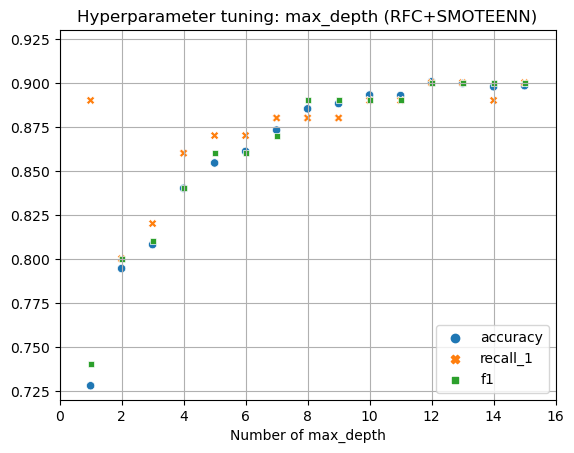

In [282]:
#max depth
sns.scatterplot(data=depth_df)
plt.title(f'Hyperparameter tuning: max_depth ({rfc}+SMOTEENN)')
plt.xlabel('Number of max_depth')
plt.xlim(0, max(depths)+1)
plt.ylim(0.72, 0.93)
plt.grid()
# Save the figure.
file_name = os.path.splitext(file_path)[0].replace('Resources', 'Data') + f'_optimized{rfc}_{formula}_max_depth.png'
plt.savefig(file_name, bbox_inches='tight', facecolor='w')
# Show Figure
plt.show()

In [283]:
fpr_l =[]
tpr_l = []
thres_l= []
for i in range(len(depths)):
    fpr, tpr, thres = roc_curve(y_test, pred_l[i], pos_label=1)
    fpr_l.append(fpr)
    tpr_l.append(tpr)
    thres_l.append(thres)

In [284]:
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

In [285]:
colors = sns.color_palette('husl', n_colors=len(depths))

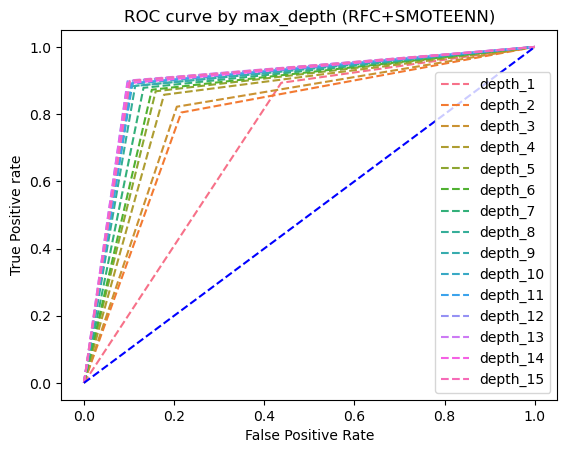

In [286]:
for i in range(len(depths)):
    plt.plot(fpr_l[i], tpr_l[i], linestyle='--', color=colors[i], label=f"depth_{i+1}") 
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.title(f'ROC curve by max_depth ({rfc}+SMOTEENN)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
# Save the figure.
# file_name = os.path.splitext(file_path)[0].replace('Resources', 'Data') + f'_optimized{rfc}_{formula}_ROC.png'
# plt.savefig(file_name, bbox_inches='tight', facecolor='w')
# Show Figure
plt.show()

## Criterion Comparison

### Default - 'gini'

In [287]:
#criterion comparison
formulas = ['gini', 'entropy']
cri_ml = []
for i in formulas:
    cri_ml.append(ml(i, mdn))

In [288]:
def sum_report(trained_ml, hyperparams):
    accuracy = []
    recall_1 = []
    f1 = []
    for i in trained_ml:
        accuracy.append(i[0])
        rec_1 = re.split(r'\s{2,}', i[1])[round(len(re.split(r'\s{2,}', i[1]))/2+2)]
        recall_1.append(rec_1)
        f1_avg = re.split(r'\s{2,}', i[1])[-4]
        f1.append(f1_avg)
    if formula in hyperparams:
        trained_df = pd.DataFrame([accuracy, recall_1, f1], columns=hyperparams, index=['accuracy', 'recall_1', 'f1'], dtype='float')
    else:
        trained_df = pd.DataFrame(list(zip(accuracy, recall_1, f1)), columns=['accuracy', 'recall_1', 'f1'], index=hyperparams, dtype='float')
    return [accuracy, recall_1, f1, trained_df]

In [289]:
#criterion comparison results
[accuracy, recall_1, f1, trained_df] = sum_report(cri_ml, formulas)
trained_df

,gini,entropy
accuracy,0.900614,0.896051
recall_1,0.900000,0.890000
f1,0.900000,0.900000


## N Estimator = # of Trees
### Default - 100

In [290]:
# Hyperparameter tuning comparison
estimators = np.arange(10,210,10)
n_ml = []
for i in estimators:
    n_ml.append(ml(formula, mdn, i))

In [291]:
# Hyperparameter tuning comparison results
[accuracy, recall_1, f1, trained_df] = sum_report(n_ml, estimators)
trained_df.head()

,accuracy,recall_1,f1
10,0.884842,0.87,0.88
20,0.895146,0.88,0.89
30,0.897578,0.89,0.90
40,0.893317,0.89,0.89
50,0.898288,0.89,0.90


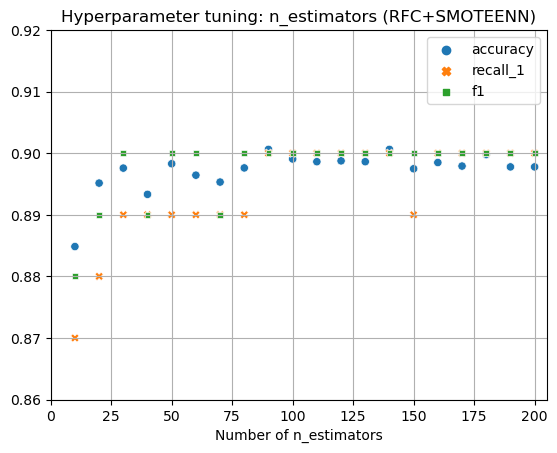

In [292]:
# n_estimator
sns.scatterplot(data=trained_df)
plt.title(f'Hyperparameter tuning: n_estimators ({rfc}+SMOTEENN)')
plt.xlabel('Number of n_estimators')
plt.xlim(0, max(estimators)+5)
plt.ylim(0.86, 0.92)
plt.grid()
# Save the figure.
# file_name = os.path.splitext(file_path)[0].replace('Resources', 'Data') + f'_optimized{rfc}_{formula}_n_estimators.png'
# plt.savefig(file_name, bbox_inches='tight', facecolor='w')
# Show Figure
plt.show()

## Max Samples - # of samples per bootstrap
### Default - None

In [293]:
#max samples = 2800

In [294]:
# Hyperparameter tuning comparison
samples = np.arange(200,4200,200)
sample_ml = []
for i in samples:
    sample_ml.append(ml(formula, mdn, nen, i))

In [295]:
# Hyperparameter tuning comparison results
[accuracy, recall_1, f1, trained_df] = sum_report(sample_ml, samples)
trained_df.head()

,accuracy,recall_1,f1
200,0.862689,0.87,0.86
400,0.861405,0.87,0.86
600,0.873265,0.88,0.87
800,0.877224,0.88,0.88
1000,0.887771,0.89,0.89


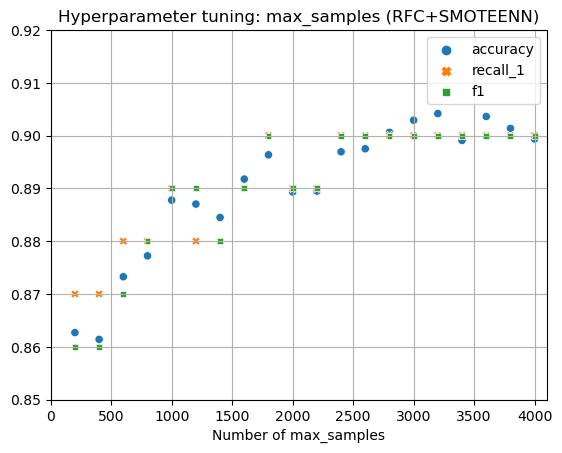

In [296]:
# max_samples
sns.scatterplot(data=trained_df)
plt.title(f'Hyperparameter tuning: max_samples ({rfc}+SMOTEENN)')
plt.xlabel('Number of max_samples')
plt.xlim(0, max(samples)+100)
plt.ylim(0.85, 0.92)
plt.grid()
# Save the figure.
# file_name = os.path.splitext(file_path)[0].replace('Resources', 'Data') + f'_optimized{rfc}_{formula}_max_samples.png'
# plt.savefig(file_name, bbox_inches='tight', facecolor='w')
# Show Figure
plt.show()

## Max Features - max features per bootstrap
### Default - sqrt(n_features)

In [297]:
#max features= 9

In [298]:
X_train.shape

(4724, 13)

In [299]:
# Hyperparameter tuning comparison
features = np.arange(1, X_train.shape[1]+1)
feature_ml = []
for i in features:
    feature_ml.append(ml(formula, mdn, nen, msn, i))

In [300]:
# Hyperparameter tuning comparison results
[accuracy, recall_1, f1, trained_df] = sum_report(feature_ml, features)
trained_df.head()

,accuracy,recall_1,f1
1,0.896187,0.89,0.90
2,0.896761,0.89,0.90
3,0.898892,0.89,0.90
4,0.892636,0.89,0.89
5,0.900205,0.90,0.90


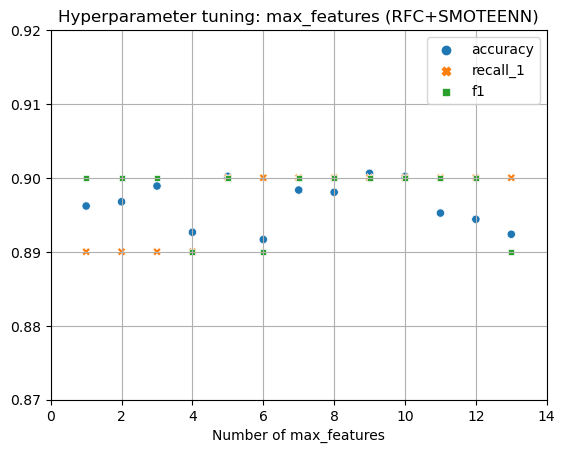

In [301]:
# max_features
sns.scatterplot(data=trained_df)
plt.title(f'Hyperparameter tuning: max_features ({rfc}+SMOTEENN)')
plt.xlabel('Number of max_features')
plt.xlim(0, max(features)+1)
plt.ylim(0.87, 0.92)
plt.grid()
# Save the figure.
# file_name = os.path.splitext(file_path)[0].replace('Resources', 'Data') + f'_optimized{rfc}_{formula}_max_features.png'
# plt.savefig(file_name, bbox_inches='tight', facecolor='w')
# Show Figure
plt.show()